# ROZWIĄZANIE PROBLEMU KOMIWOJAŻERA ALGORYTMEM GENETYCZNYM

# Natalia Kubańska IIAD

In [1]:
import numpy  as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 

from scipy.spatial import distance_matrix
from itertools import permutations
import random

## Generowanie współrzędnych miast

In [2]:
def generateCities(num_cities): 
    np.random.seed(101) 
    cities = np.random.randint(0, 300, (num_cities, 2))
    return pd.DataFrame(cities, columns = ['X', 'Y'])

## Generowanie macierzy odległości między miastami 

In [3]:
def calcDistance(df):
    dist = distance_matrix(df,df)
    return pd.DataFrame(dist, columns=df.index, index=df.index)

## Generowanie początkowej populacji

In [4]:
def initializePopulation(num_individuals, num_cities):
    population = []
    for _ in range(num_individuals):
        individual = list(range(1, num_cities))  # Omiń pierwsze miasto traktując je jako startowe/koncowe
        random.shuffle(individual)
        population.append(individual)
    return population

## Obliczanie całkowitej odległości trasy dla każdego osobnika

In [5]:
def calculateFitness(individual, distance_matrix):
    total_distance = distance_matrix[0, individual[0]]  # Dystans z pierwszego miasta do pierwszego w trasie
    for i in range(len(individual) - 1):
        total_distance += distance_matrix[individual[i], individual[i+1]]
    total_distance += distance_matrix[individual[-1], 0]  # Powrót do pierwszego miasta
    return total_distance

## Selekcja ruletkowa

In [6]:
def rouletteSelection(population, fitness_scores):
    sorted_indices = np.argsort(fitness_scores)
    ranks = np.argsort(sorted_indices) + 1
    
    selection_probabilities = 1 / ranks
    selection_probabilities = selection_probabilities / np.sum(selection_probabilities)
    
    parents_indices = np.random.choice(len(population), size = 2, replace=False, p=selection_probabilities)
    return population[parents_indices[0]], population[parents_indices[1]]    

## Krzyżowanie

In [7]:
def crossover(parent1, parent2, crossover_rate=0.9):
    if np.random.rand() < crossover_rate:
        cut_point = np.random.randint(1, len(parent1)-1)
        child1 = parent1[:cut_point] + parent2[cut_point:]
        child2 = parent2[:cut_point] + parent1[cut_point:]

        child1 = fix_repetition(child1, parent1, parent2)
        child2 = fix_repetition(child2, parent2, parent1)
    else:
        child1, child2 = parent1[:], parent2[:]
    
    return child1, child2

In [8]:
def fix_repetition(child, parent1, parent2):
    seen = set()
    duplicates = []

    for index, gene in enumerate(child):
        if gene in seen:
            duplicates.append(index)
        else:
            seen.add(gene)
    missing = set(parent1) - seen

    for index in duplicates:
        child[index] = missing.pop()

    return child

## Mutacja

In [9]:
def mutate(individual, mutation_rate):
    if np.random.rand() < mutation_rate:
        idx1, idx2 = np.random.choice(len(individual), 2, replace=False)
        individual[idx1], individual[idx2] = individual[idx2], individual[idx1]

    return individual

## Generowanie nowej populacji

In [10]:
def generateNewPopulation(population, fitness_scores, crossover_rate, mutation_rate, num_individuals):
    new_population = []

    best_individuals = sorted(range(len(fitness_scores)), key=lambda i: fitness_scores[i])[:2]
    elite = [population[i] for i in best_individuals]  # Wybór dwóch najlepszych osobników
    new_population.extend(elite)
    
    while len(new_population) < num_individuals:
        parent1, parent2 = rouletteSelection(population, fitness_scores)
        child1, child2 = crossover(parent1, parent2, crossover_rate)
        child1 = mutate(child1, mutation_rate)
        child2 = mutate(child2, mutation_rate)
        new_population.extend([child1, child2])
    return new_population[:num_individuals]   

## Algorytm genetyczny 

In [11]:
def geneticAlgorithm(num_cities=10, num_individuals=50, generations=100, mutation_rate=0.01, crossover_rate=0.9, boostMR=False):
    
    cities = generateCities(num_cities)
    dist_matrix = calcDistance(cities)
    population = initializePopulation(num_individuals, num_cities)

    best_fitness_over_generations = []
    all_fitness_scores = []

    for generation in range(generations):
        fitness_scores = [calculateFitness(individual, dist_matrix.values) for individual in population]
        population = generateNewPopulation(population, fitness_scores, crossover_rate, mutation_rate, num_individuals)
      
        if generation == 200 and boostMR:
            mutation_rate = 0.3
 
        current_best_fitness = min(fitness_scores)
        best_fitness_over_generations.append(current_best_fitness)
        all_fitness_scores.append(fitness_scores)
        
        
    best_fitness_index = np.argmin([calculateFitness(individual, dist_matrix.values) for individual in population])
    best_individual = population[best_fitness_index]
    best_distance = calculateFitness(best_individual, dist_matrix.values)
    
    return best_individual, best_distance, all_fitness_scores, best_fitness_over_generations, cities

## Wizualizacje

In [12]:
def plotRoute(cities, best_route):
    route = np.append([0], best_route + [0])  # Dodanie miasta startowego i końcowego
    plt.figure(figsize=(5, 5))

    for i in range(1, len(route)):
        start_city = cities.iloc[route[i - 1]]
        end_city = cities.iloc[route[i]]
        plt.plot([start_city['X'], end_city['X']], [start_city['Y'], end_city['Y']], 'o-', ms=5, markeredgecolor='purple', markerfacecolor='purple', color='orange')

    plt.title('Najlepsza trasa komiwojażera')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.xlim(0,300)
    plt.ylim(0,300)
    plt.show()

In [13]:
def plotCombined(best_fitness_over_generations, all_fitness_scores):
    fig, axs = plt.subplots(1, 2, figsize=(16, 6)) 

    axs[0].plot(best_fitness_over_generations, marker='o', linestyle='-', color='blue')
    axs[0].set_title('Zmiana wartości funkcji fitness najlepszego osobnika')
    axs[0].set_xlabel('Pokolenie')
    axs[0].set_ylabel('Funkcja fitness')

    generations = range(len(all_fitness_scores))
    for i, gen_scores in enumerate(all_fitness_scores):
        axs[1].scatter([i] * len(gen_scores), gen_scores, alpha=0.5, edgecolor='none')
    axs[1].set_title('Wyniki fitness wszystkich osobników w każdej generacji')
    axs[1].set_xlabel('Pokolenie')
    axs[1].set_ylabel('Funkcja Fitness')

    plt.tight_layout()
    plt.show()


### Rozwiązanie z użyciem mutation_rate = 0.01

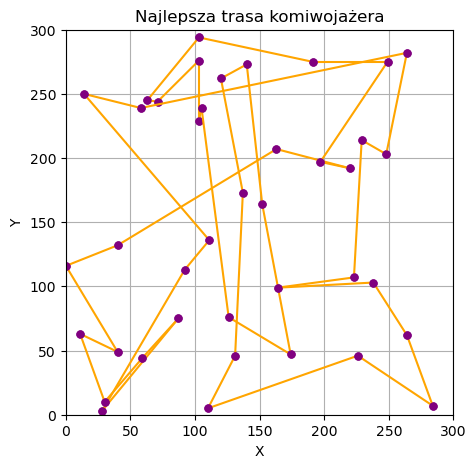

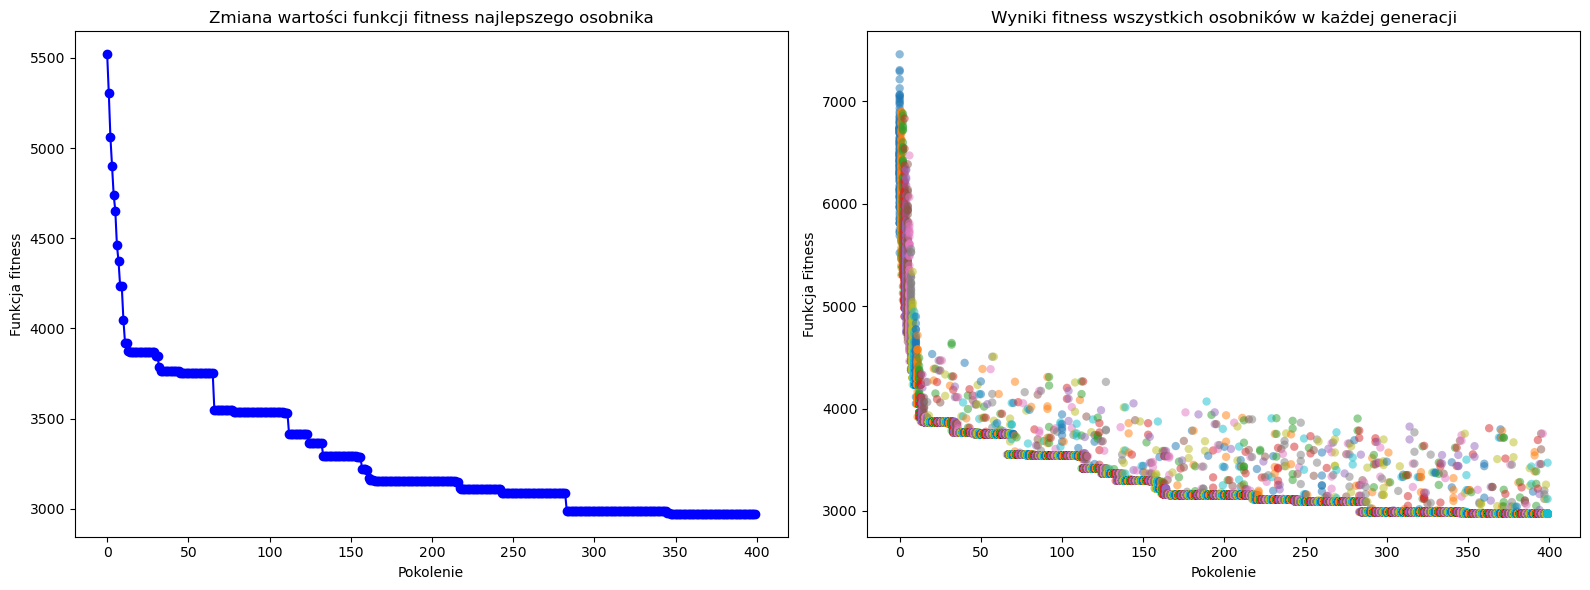

Najlepsza znaleziona trasa ma długość: 2972.9701601818438


In [14]:
best_individual, best_distance, all_fitness_scores, best_fitness_over_generations, cities = geneticAlgorithm(num_cities=40, num_individuals=150, generations=400, mutation_rate=0.01, crossover_rate= 0.95)
plotRoute(cities, best_individual)
plotCombined(best_fitness_over_generations,  all_fitness_scores)
print(f'Najlepsza znaleziona trasa ma długość: {best_distance}')

### Rozwiązanie z użyciem mutation_rate = 0.05

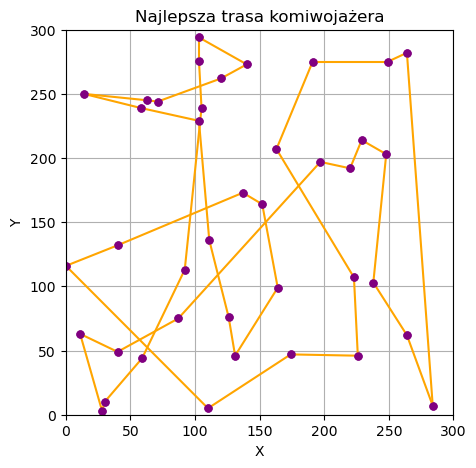

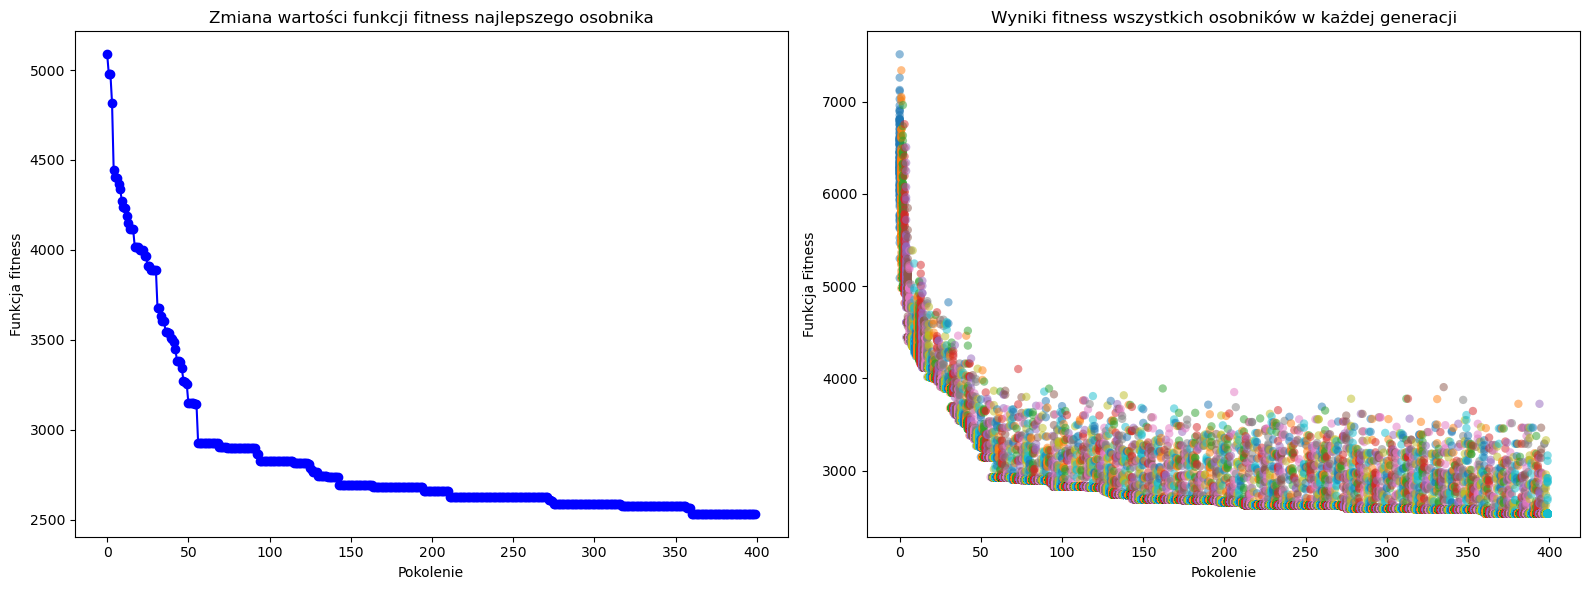

Najlepsza znaleziona trasa ma długość: 2532.2559972436666


In [15]:
best_individual, best_distance, all_fitness_scores, best_fitness_over_generations, cities = geneticAlgorithm(num_cities=40, num_individuals=150, generations=400, mutation_rate=0.05, crossover_rate= 0.95)
plotRoute(cities, best_individual)
plotCombined(best_fitness_over_generations,  all_fitness_scores)
print(f"Najlepsza znaleziona trasa ma długość: {best_distance}")

### Rozwiązanie z użyciem mutation_rate = 0.01, które przy 200 iteracji zwiększa sie do 0.3

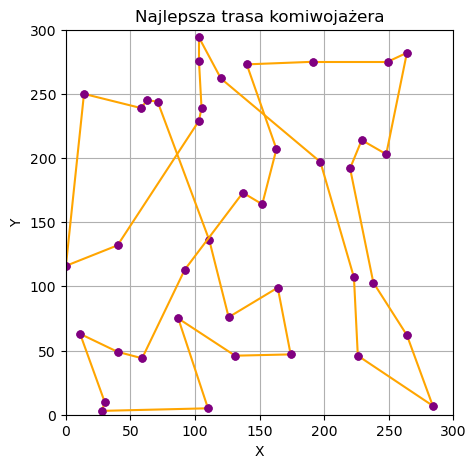

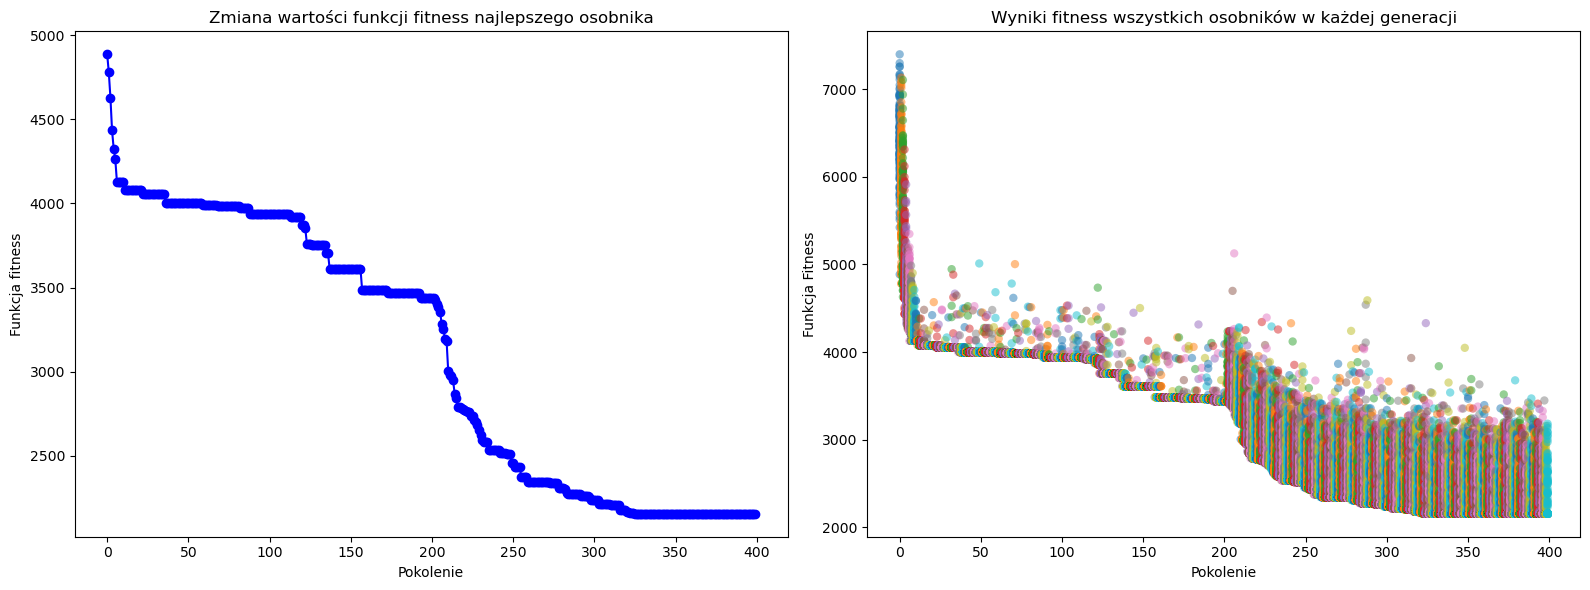

Najlepsza znaleziona trasa ma długość: 2155.886825609928


In [17]:
best_individual, best_distance, all_fitness_scores, best_fitness_over_generations, cities = geneticAlgorithm(num_cities=40, num_individuals=150, generations=400, mutation_rate=0.01, crossover_rate= 0.95,boostMR=True)
plotRoute(cities, best_individual)
plotCombined(best_fitness_over_generations,  all_fitness_scores)
print(f'Najlepsza znaleziona trasa ma długość: {best_distance}')

### Rozwiązanie z użyciem mutation_rate = 0.05, które przy 200 iteracji zwiększa sie do 0.3

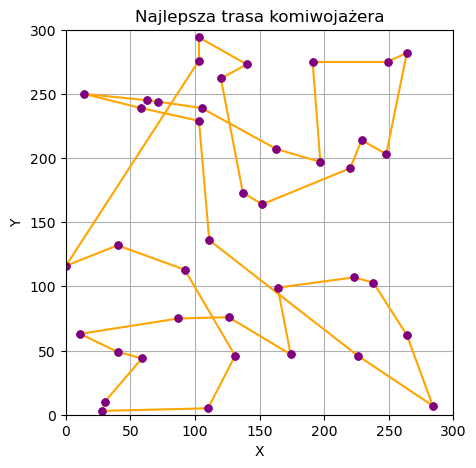

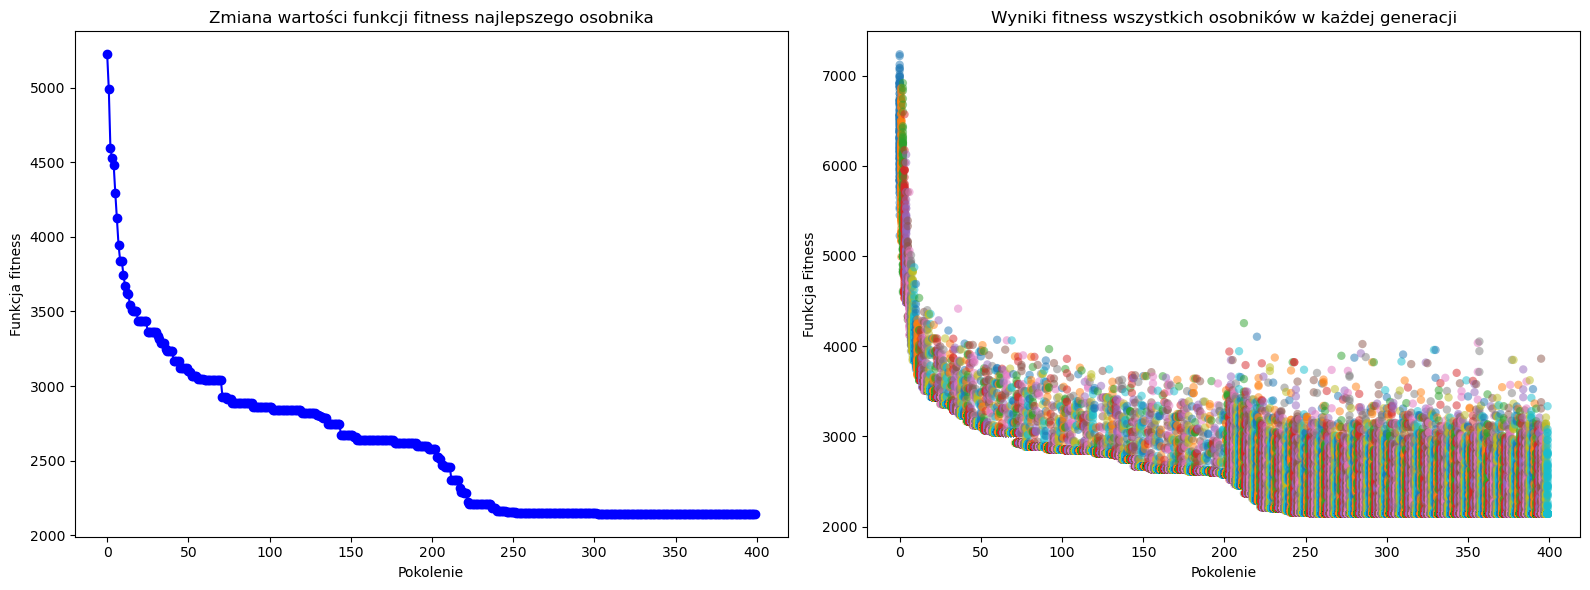

Najlepsza znaleziona trasa ma długość: 2143.490883842246


In [18]:
best_individual, best_distance, all_fitness_scores, best_fitness_over_generations, cities = geneticAlgorithm(num_cities=40, num_individuals=150, generations=400, mutation_rate=0.05, crossover_rate= 0.95, boostMR=True)
plotRoute(cities, best_individual)
plotCombined(best_fitness_over_generations,  all_fitness_scores)
print(f'Najlepsza znaleziona trasa ma długość: {best_distance}')

## Podsumowanie

**Uwagi ogóle**

Zdecydowałam się na użycie algorytmu w wersji, w której 2 najlepszych osobników zawsze przechodzi do następnego pokolenia, aby mieć gwarancję, że w pewnym momencie nie zgubię optymalnego rozwiązania. Wersją mutacji, którą zaimplementowałam polega na zamianie alleli na losowych locusach.

**Wnioski**

Bez wątpienia udało się udowodnić, że wraz z kolejnymi generacjami następuje optymalizacja długości trasy i rozwiązanie jest coraz lepsze. 
Przyjrzałam się głównie czterem przypadkom:
- mutation rate równy 0.01
- mutation rate równy 0.05
- mutation rate równy 0.01 i przy 200 iteracji zwrasta do 0.3
- mutation rate równy 0.05 i przy 200 iteracji zwrasta do 0.3

**Pierwszy** z przypadków zdaje się być najgorszą opcją. Optymalizacja rozwiązania spada gwałtowanie do około 15 pokolenia, a później fazami utrzymuje się i dopiero poprawia wynik. Patrząć na wynik funckji dopasowania wszystkich osobników możemy dostrzec, że kropek jest dużo mniej porównując z innymi wersjami, wieć sporo rozwiązań zostało zduplikowanych. 

W wersji z **mutation_rate=0.05** możemy zauważyć, że intensywna optymalizacja trwa do 50 pokolenia, a później algorytm zwalnia fazowo poprawiając rozwiązanie. Wynik jest jednak znacznie lepszy i trasa jest krótsza o około 400 jednostek odległościowych. 

Jeśli spojrzymy na **dwa kolejne przypadki**, w których zgodnie z tym co zasugerowano we wprowadzenie po zwolnieniu algorytmu zwiększymy prawdopodobieństwo mutacji to rozwiązania są dużo lepsze. Wynik dla wersji z początkowym prawdopodobieństwem mutacji równym 0.05 jest nieco lepszy, ale różnica jest znikoma. W tym pierwszym optymalizacja polepsza się przez większą liczbę pokoleń i stabilizuje przy ~330, natomiast w tym drugim przy ~250 algorytm już zwolnił. Moglibyśmy postawić tezę, że jeśli zależy nam na użyciu jak najmniejszej liczby pokoleń to ostatnia wersja parametrów wygrywa. Warto też dodać, że wartości dla wszystkich potomków w tych wersjach są bardzo zróżnicowane i dużo mniej stabilne.

Rozwiązania są jednak generowane losowo więc, aby mieć pewność co do moich założeń związanych z doborem parametrów, należałoby to przetestować wystarczającą ilość razy.